The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.6.0'

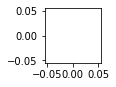

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [49]:
import aggets.ds.hyper_f_load as hyper_f_load
data = hyper_f_load.load()

In [50]:
import aggets.ds.aggregate_nd as agg_nd
cols = ['att1', 'att2', 'att3', 'att4', 'att5', 'att6', 'att7', 'att8', 'att9', 'att10']
train_np = agg_nd.as_np(data['train'], cols, 'class')
val_np = agg_nd.as_np(data['val'], cols, 'class')
test_np = agg_nd.as_np(data['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=500, e=0.00001, hist_bins=20, hist_dim=1)

ranges -> [[-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000080e+00]
 [-8.9999994e-06  1.0000100e+00]
 [-9.9999997e-06  1.0000089e+00]
 [-6.9999996e-06  1.0000070e+00]
 [-5.9999998e-06  1.0000089e+00]
 [-9.9999997e-06  1.0000100e+00]]


In [4]:
window.init_structures()

In [51]:
import aggets.util as util
#util.save(window, path='nwindow_02.bin')
# w = util.load(path='nwindow_01.bin') # 5 bins, 2 dim, 500ws
w = util.load(path='nwindow_02.bin') # 20 bins, 1 dim, 500ws

In [52]:
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([1400, 5, 2, 10, 20])
torch.Size([400, 5, 2, 10, 20])
torch.Size([200, 5, 2, 10, 20])
models
torch.Size([1400, 5, 11])
torch.Size([400, 5, 11])
torch.Size([200, 5, 11])

sets


[torch.Size([32, 10, 2, 10, 20]), torch.Size([32, 5, 11])]

In [65]:
SIZE = 2 * 10 * 20
FEATURES_N = 11
SIZE_ALL = SIZE + FEATURES_N

# AGG -> LR

## LSTM with attention mechanism

training model autoreg-lstm
saving model MTL=0.05841283742252583, MVL=0.0842691637331345
saving model MTL=0.02127079933469746, MVL=0.08322885137845258
saving model MTL=0.016460338470092567, MVL=0.07501325884559115
saving model MTL=0.014362472568720168, MVL=0.07232825513013073
saving model MTL=0.012488703827120466, MVL=0.07041835968123107
saving model MTL=0.0118352826513041, MVL=0.06610308679156617
saving model MTL=0.010969514679592875, MVL=0.06202477650319944
saving model MTL=0.010339313929188087, MVL=0.06075149646303693
saving model MTL=0.00981537443650071, MVL=0.060321536281558334
saving model MTL=0.009305284847827276, MVL=0.05846347403330881
saving model MTL=0.009109744557484228, MVL=0.05833741460667282
saving model MTL=0.008620970352436952, MVL=0.05812383888930571


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

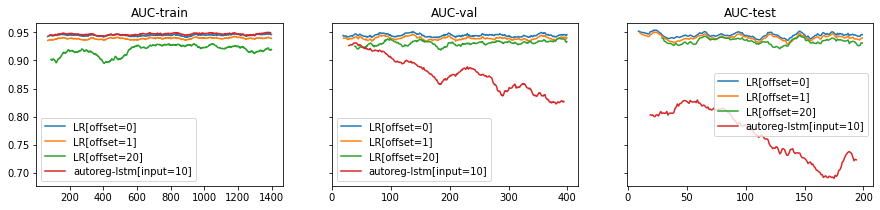

In [54]:
import aggets.model.aggregate_pp as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=SIZE, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=1, out_features=FEATURES_N)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

## w/o attention

training model autoreg-lstm
saving model MTL=0.10177840846955502, MVL=0.13976382549668923
saving model MTL=0.055466245379178755, MVL=0.10058322170230209
saving model MTL=0.034955644370636085, MVL=0.08825934995881847
saving model MTL=0.025330682881691487, MVL=0.0877337965076087
saving model MTL=0.0234610009251789, MVL=0.08749362704206685
saving model MTL=0.0220679309442296, MVL=0.08573218276266192


<Figure size 432x288 with 0 Axes>

saving model MTL=0.020738339746877346, MVL=0.0856959170616064
saving model MTL=0.019962208216778143, MVL=0.0852395770002584


<Figure size 432x288 with 0 Axes>

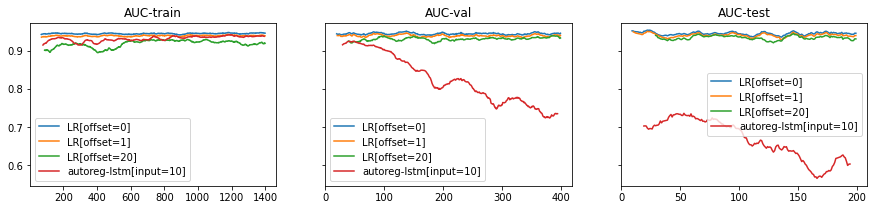

In [73]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=SIZE, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=1, out_features=FEATURES_N)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

# ALL -> LR
## with attention

training model autoreg-lstm
saving model MTL=0.08469950558815134, MVL=0.09068938301967792
saving model MTL=0.02367872473556325, MVL=0.0799669697880745
saving model MTL=0.015128310194693953, MVL=0.07484569082983204
saving model MTL=0.013398648089458865, MVL=0.06918285701607095
saving model MTL=0.01229802424234042, MVL=0.0681338548415997
saving model MTL=0.011484301352899195, MVL=0.06606084261028493
saving model MTL=0.010958615591758132, MVL=0.0621032040016573
saving model MTL=0.010278943372452588, MVL=0.061485704156707545
saving model MTL=0.010037869708569644, MVL=0.05927511671038925
saving model MTL=0.009851838114418192, MVL=0.05879922174527997
saving model MTL=0.009646685218893438, MVL=0.05592162210921772
saving model MTL=0.008991709931792203, MVL=0.05543700190352612


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

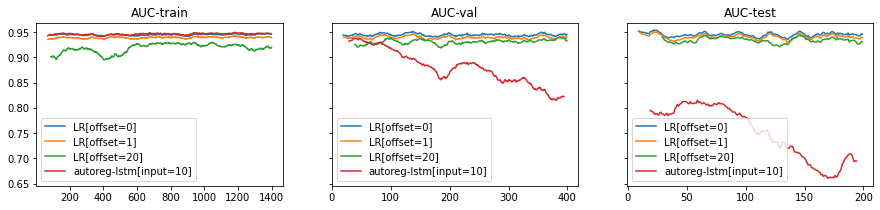

In [72]:
import aggets.model.aggregate_pp as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=SIZE_ALL, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=2, out_features=FEATURES_N)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

## w/o attention

training model autoreg-lstm
saving model MTL=0.06698301940950381, MVL=0.09401451026807066
saving model MTL=0.021524949540053646, MVL=0.08841840996116888
saving model MTL=0.017276878799161604, MVL=0.08637518423502563
saving model MTL=0.014676740397334374, MVL=0.07853096063996924
saving model MTL=0.013244605305591762, MVL=0.07754338288404902
saving model MTL=0.012203831697732622, MVL=0.07162087251905536
saving model MTL=0.009771824870172734, MVL=0.07114014389817833
saving model MTL=0.009625491153981005, MVL=0.06167027317598218


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

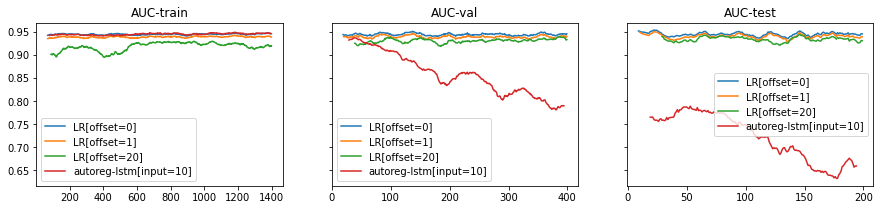

In [60]:
import aggets.model.aggregate_pp as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=SIZE_ALL, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=2, out_features=FEATURES_N)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

# AGG[0] -> AGG[0]
## with attention

training model autoreg-lstm
saving model MTL=0.05227206808027871, MVL=0.037775701736329034
saving model MTL=0.025795990831876565, MVL=0.02989888997351537
saving model MTL=0.02414720508039271, MVL=0.029466122541515552
saving model MTL=0.02366922179732574, MVL=0.028353673604423882
saving model MTL=0.023392256486033082, MVL=0.02833993284062284
saving model MTL=0.023166957242978275, MVL=0.02803578899532068
saving model MTL=0.02300679017234286, MVL=0.027897255983753283
saving model MTL=0.022958677561116327, MVL=0.02728916051202133
saving model MTL=0.022879855049381014, MVL=0.02691634561194748
saving model MTL=0.02286494326769212, MVL=0.02671584847276328
saving model MTL=0.022809420669570975, MVL=0.02644593671697085
saving model MTL=0.022766354912464773, MVL=0.026387875166828514
saving model MTL=0.022705328121029454, MVL=0.02590529929052611
saving model MTL=0.022662011598911853, MVL=0.02561664303428814
saving model MTL=0.02264238978573762, MVL=0.0252948986885489
saving model MTL=0.0226241322

<Figure size 432x288 with 0 Axes>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

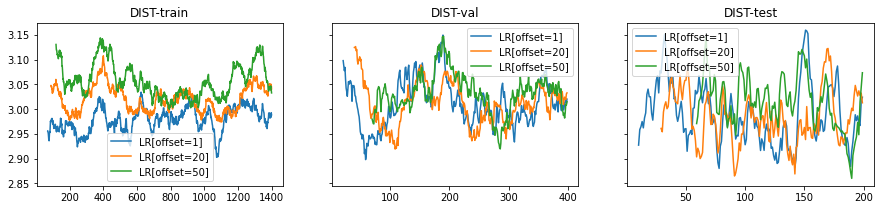

In [61]:
import aggets.model.aggregate_pp as agg_m
import aggets.model.simple as simple
# HIST[0] -> HIST[0]
size = 200#2250 // 2
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg[0]', target='agg[0]', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

## w/o attention

training model autoreg-lstm
saving model MTL=0.06396988910033342, MVL=0.039504942224651084
saving model MTL=0.02678818008734272, MVL=0.031129315464955863
saving model MTL=0.0254250901042048, MVL=0.02998029223841722
saving model MTL=0.024092846515870424, MVL=0.02967410491871052
saving model MTL=0.023794423481193157, MVL=0.029013861489833377
saving model MTL=0.023502659223495273, MVL=0.028983896995177033
saving model MTL=0.023410611495443986, MVL=0.02894499122363622
saving model MTL=0.02335148514889249, MVL=0.02864826290455998
saving model MTL=0.02324207186049551, MVL=0.028646786559800633
saving model MTL=0.023200773146994615, MVL=0.02844591118151047
saving model MTL=0.023167308975318702, MVL=0.027993423070331088
saving model MTL=0.022975319526542765, MVL=0.027538248780565183
saving model MTL=0.022752646493528962, MVL=0.02736070694127044
saving model MTL=0.022726251683924177, MVL=0.027347673188711775
saving model MTL=0.02272540668384471, MVL=0.02720126863874373
saving model MTL=0.0227242

<Figure size 432x288 with 0 Axes>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

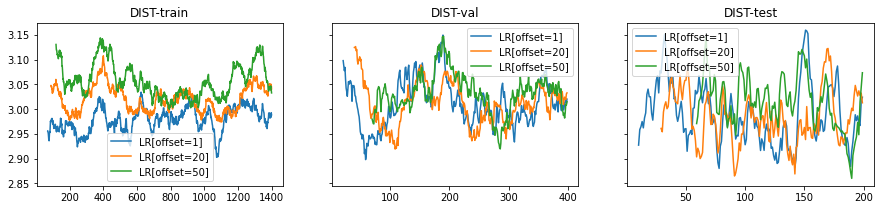

In [68]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST[0] -> HIST[0]
size = 200#2250 // 2
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg[0]', target='agg[0]', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

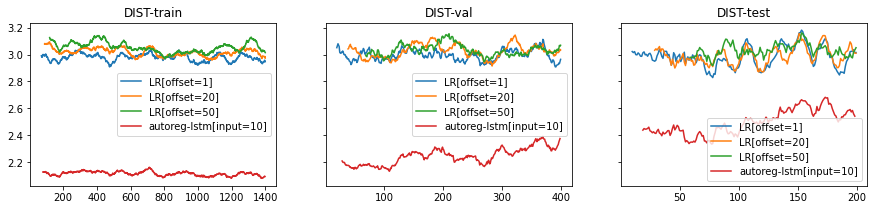

In [20]:
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

# AGG -> AGG
## WITH ATTENTION

## W/O ATTENTION

# LR -> LR
## with attention

training model autoreg-lstm
saving model MTL=0.06128065202230682, MVL=0.08103250541159364
saving model MTL=0.02102352622982269, MVL=0.07253430191366399
saving model MTL=0.01506190159903144, MVL=0.06168324274362111
saving model MTL=0.012919792476268958, MVL=0.05783607200032375
saving model MTL=0.012205401323907386, MVL=0.05430994201146188
saving model MTL=0.011730372592429136, MVL=0.050768075480324325
saving model MTL=0.011433845591915917, MVL=0.049959588490548684
saving model MTL=0.011220588340222286, MVL=0.049493866865752176
saving model MTL=0.010889929968194203, MVL=0.0490903163359302


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

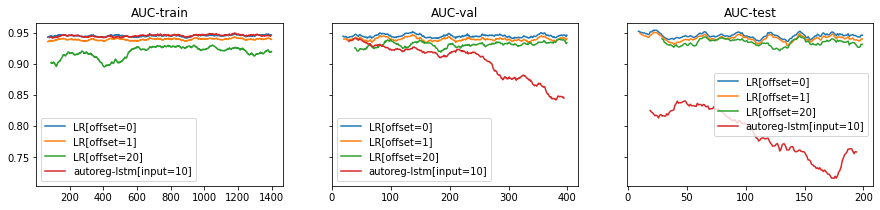

In [70]:
import aggets.model.aggregate_pp as agg_m
import aggets.model.simple as simple
# LR -> LR
size = FEATURES_N
hidden = 16
inp = simple.mlp(features=size, num_layers=1, out_features=hidden)
out = simple.mlp(features=hidden, num_layers=1, out_features=size)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=16)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=20, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'lr', 'target':'lr'})

## w/o attention

training model autoreg-lstm
saving model MTL=0.12125740049209463, MVL=0.15767797656723712
saving model MTL=0.05399483670630763, MVL=0.09311597843150624
saving model MTL=0.0349566258301246, MVL=0.08448317488197421
saving model MTL=0.015238809892864821, MVL=0.08294840279172679
saving model MTL=0.014459608534720086, MVL=0.08052745082827865
saving model MTL=0.014193551799428354, MVL=0.07865447563226105
saving model MTL=0.013487079536997229, MVL=0.07809158182535016
saving model MTL=0.013301281563182306, MVL=0.07765451708778007
saving model MTL=0.013113148514747895, MVL=0.07681019860701482
saving model MTL=0.013018389459922567, MVL=0.07466599552846345
saving model MTL=0.012869719321483291, MVL=0.07362101685072554
saving model MTL=0.01262265591010932, MVL=0.07344985844903305
saving model MTL=0.012536766925989757, MVL=0.0729254424938413
saving model MTL=0.012289179137088187, MVL=0.07265933920614055
saving model MTL=0.012136215399864907, MVL=0.07220670257191189
saving model MTL=0.01182784620792

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

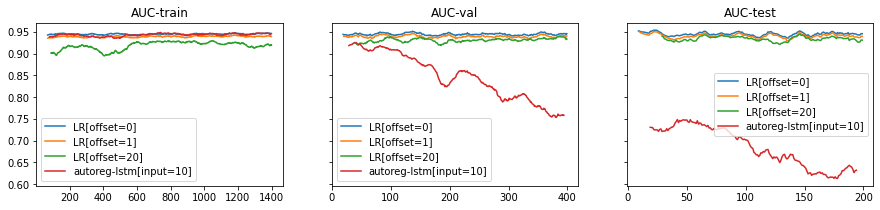

In [71]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# LR -> LR
size = FEATURES_N
hidden = 16
inp = simple.mlp(features=size, num_layers=1, out_features=hidden)
out = simple.mlp(features=hidden, num_layers=1, out_features=size)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=16)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=20, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'lr', 'target':'lr'})

training model autoreg-lstm
saving model MTL=0.4741213728892638, MVL=0.3689233851237375
saving model MTL=0.1597724387310617, MVL=0.3362335391709062
saving model MTL=0.1515139351654712, MVL=0.25200953395640263
saving model MTL=0.12229025020577391, MVL=0.1736828758091223
saving model MTL=0.10781886064649178, MVL=0.16070879287407047
saving model MTL=0.09211163830509933, MVL=0.15925990411492644
saving model MTL=0.08137580766106531, MVL=0.1591023148083296
saving model MTL=0.08030585426202018, MVL=0.1564094907924777
saving model MTL=0.07945168176279639, MVL=0.1547835290920539


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

TypeError: tuple indices must be integers or slices, not tuple

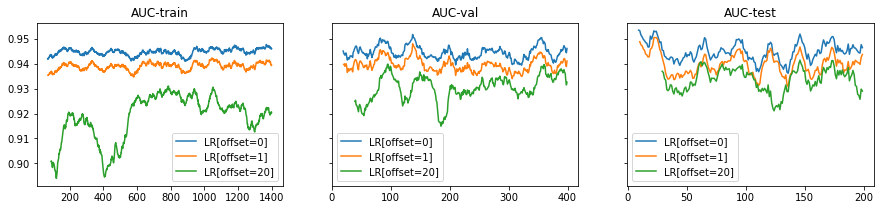

In [488]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> HIST+LR
hidden = 512
flatcat = agg_m.FlatCat()

inp = nn.Sequential(
    flatcat,
    simple.mlp(features=2261, num_layers=2, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=2, out_features=2261),
    flatcat.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=1, hidden=hidden, num_layers=2)

loss = nn.MSELoss()

def criterion(x, y):
    return loss(x[0], y[0]) + loss(x[1], y[1])
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='all', target='all', log=False,
                          criterion=criterion)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'all'}, select=lambda x: x[1])

training model fourier
saving model MTL=0.026372179833300615, MVL=0.02280151172250998


<Figure size 432x288 with 0 Axes>

saving model MTL=0.0226743803145962, MVL=0.022788796665482832


<Figure size 432x288 with 0 Axes>

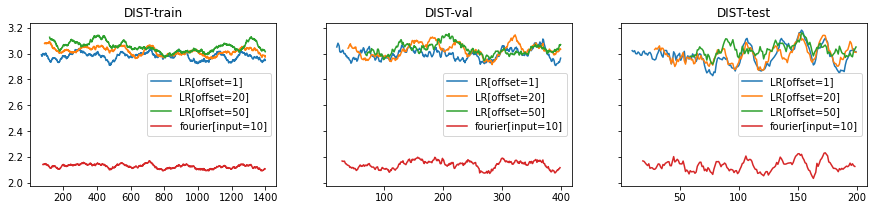

In [28]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST[0] -> HIST[0]
size = 20

frr = fourier.HistogramLerner(size=size, hists=10, types=1, t_in=10)
frr = fourier.FAdapter2(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='agg[0]', target='agg[0]', log=False)

# ------- p hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

out torch.Size([1389, 1, 10, 20])
out torch.Size([389, 1, 10, 20])
out torch.Size([189, 1, 10, 20])


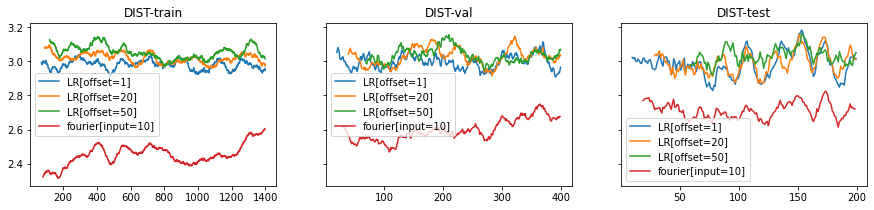

In [27]:
# ------- p hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0]) # sample 0, hist_type 0
w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

training model fourier
d-2-shape torch.Size([1, 1, 10, 1])
saving model MTL=0.02589153977743256, MVL=0.02398524170771974
saving model MTL=0.03972468314128458, MVL=0.02362888285004702


<Figure size 432x288 with 0 Axes>

saving model MTL=0.023118082938049365, MVL=0.02339066839853271


<Figure size 432x288 with 0 Axes>

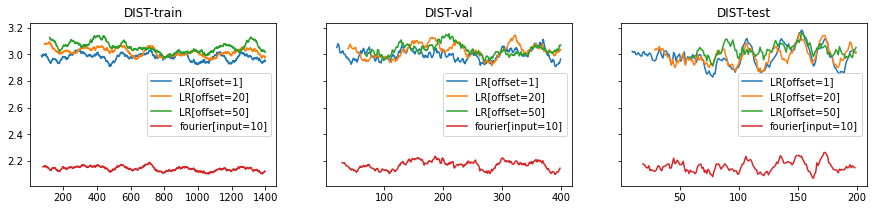

In [299]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST[0] -> HIST[0]
size = 20

frr = fourier.HistogramLerner(extra_dims=1, t_in=10)
frr = fourier.FAdapter2(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='agg[0]', target='agg[0]', log=False)

# ------- p hist
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0])
w.plot_model_agg_dist(model=frr, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

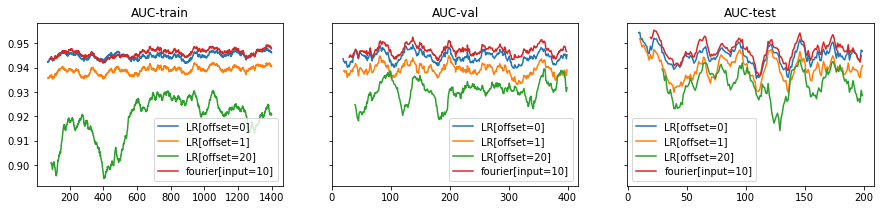

In [303]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# LR -> LR
size = 11

frr = fourier.HistogramLerner(extra_dims=0, t_in=10)
frr = fourier.FAdapter2(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'lr', 'target':'lr'})

training model fourier
d-2-shape torch.Size([1, 1, 2, 1, 1])
d-3-shape torch.Size([1, 1, 1, 10, 1])
saving model MTL=0.0836253888016447, MVL=0.2675557344174776
saving model MTL=0.08706899443555863, MVL=0.20790605515730184


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

IndexError: tuple index out of range

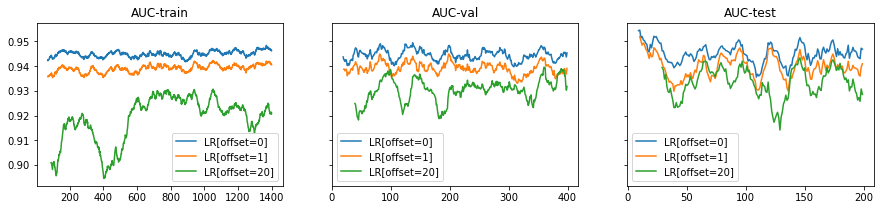

In [335]:
import torch.nn as nn

class MultiLearner(nn.Module):
    def __init__(self):
        super(MultiLearner, self).__init__()
        self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
        self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
        self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

    def forward(self, x):
        ts, lr = x
        lr = self.lr_learner(lr)
        ts = self.agg_learner(ts)
        lr = lr.flatten(start_dim=1)
        ts = ts.flatten(start_dim=1)
        return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)

    
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST+LR -> LR
frr = MultiLearner()
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='all', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'all', 'target':'lr'})

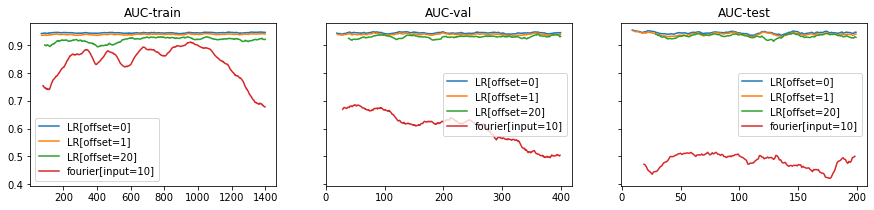

In [340]:
class MultiLearner(nn.Module):
    def __init__(self):
        super(MultiLearner, self).__init__()
        self.lr_learner = fourier.HistogramLerner(extra_dims=0, t_in=10)
        self.agg_learner = fourier.HistogramLerner(extra_dims=2, t_in=10)
        self.fc = simple.mlp(400 + 11, num_layers=2, out_features=11)

    def forward(self, x):
        ts, lr = x
        lr = self.lr_learner(lr)
        ts = self.agg_learner(ts)
        lr = lr.flatten(start_dim=1)
        ts = ts.flatten(start_dim=1)
        return self.fc(torch.cat([ts, lr], dim=-1)).reshape(ts.shape[0], 1, 11)
frr2 = MultiLearner()
frr2.window_config = frr.window_config
frr2.name = frr.name
frr2.lr_learner = frr.lr_learner
frr2.agg_learner = frr.agg_learner
frr2.fc = frr.fc
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr2, axs=axs, other={'source':'all', 'target':'lr'})

training model DUMMY
saving model MTL=0.01517420029694881, MVL=0.015153000085446679
saving model MTL=0.015175007958682853, MVL=0.015146846684520363
saving model MTL=0.015199506651063304, MVL=0.015145258962741642
saving model MTL=0.015179206266862536, MVL=0.01514203557897298
saving model MTL=0.015138362040914117, MVL=0.0151413960504483
saving model MTL=0.015152367233478148, MVL=0.015139034491215573


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

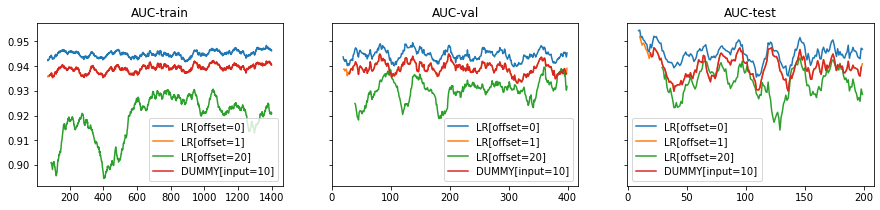

In [330]:
import aggets.model.aggregate as agg_m_old
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST+LR -> LR
dmy = agg_m_old.DummyNet()
dmy.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
dmy.name = 'DUMMY'
train.train_window_models([dmy], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='all', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(dmy, axs=axs, other={'source':'all', 'target':'lr'})